In [ ]:
import os, re, random
from os.path import join
import zipfile
from pathlib import Path
import shutil
from sklearn.datasets import load_files
import pandas as pd
import numpy as np
np.random.seed(2)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, Activation
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
INPUT_PATH = '/content/drive/My Drive/flowers'
print(os.listdir(INPUT_PATH))

['rose', 'sunflower', 'dandelion', 'daisy', 'tulip']


In [ ]:
img_folders = [join(INPUT_PATH, dir) for dir in os.listdir(INPUT_PATH)]
list(img_folders)

['/content/drive/My Drive/flowers/rose',
 '/content/drive/My Drive/flowers/sunflower',
 '/content/drive/My Drive/flowers/dandelion',
 '/content/drive/My Drive/flowers/daisy',
 '/content/drive/My Drive/flowers/tulip']

In [ ]:
images = load_files(INPUT_PATH, random_state=42, shuffle=True)
X = np.array(images['filenames'])
y = np.array(images['target'])
labels = np.array(images['target_names'])
pyc_file = (np.where(file==X) for file in X if file.endswith(('.pyc','.py')))
for i in pyc_file:
    X = np.delete(X, i)
    y = np.delete(y, i)

In [ ]:
print(f'Target labels (digits) - {y}')
print(f'Target labels (names) - {labels}')
print(f'Number of uploaded images : {X.shape[0]}')

Target labels (digits) - [2 1 3 ... 3 4 1]
Target labels (names) - ['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']
Number of uploaded images : 4323


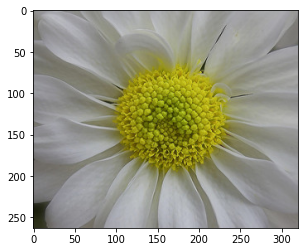

In [ ]:
img = plt.imread('/content/drive/My Drive/flowers/daisy/100080576_f52e8ee070_n.jpg')
plt.imshow(img);

In [ ]:

flowers = pd.DataFrame({'species': y})
flowers.count()

species    4323
dtype: int64

In [ ]:
flowers['flower'] = flowers['species'].astype('category')
labels = flowers['flower'].cat.categories
labels

Int64Index([0, 1, 2, 3, 4], dtype='int64')

In [ ]:

image_size = 150
def imageLoadConverter(img_paths):
    
    images = [load_img(img_path, target_size=(image_size, image_size)) for img_path in img_paths]
    
    images_array = np.array([img_to_array(img) for img in images])
    
    return(images_array)


X = np.array(imageLoadConverter(X))

In [ ]:
num_classes = len(np.unique(y))
print(f'Classes: {num_classes} and corresponding labels: {labels}')

Classes: 5 and corresponding labels: Int64Index([0, 1, 2, 3, 4], dtype='int64')


In [ ]:
y = to_categorical(y, num_classes)
print(y.shape)

(4323, 5)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=2)

total_X_train = X_train.shape[0]
total_X_val = X_val.shape[0]
total_X_test = X_test.shape[0]
print(f'Train: {total_X_train}')
print(f'Validation: {total_X_val}')
print(f'Test: {total_X_test}')

Train: 3458
Validation: 432
Test: 433


In [ ]:
input_shape = (image_size, image_size, 3)
batch_size = 8
epochs = 20
pre_trained_model = InceptionV3(input_shape = input_shape, include_top = False, weights='imagenet')

In [ ]:
print(pre_trained_model.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, 74, 74, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 74, 74, 32)   0           batch_normalization_283[0][0]    
_______________________________________________________________________________________

In [ ]:
len(pre_trained_model.layers)

311

In [ ]:
for layer in pre_trained_model.layers:
     layer.trainable = False

In [ ]:
x = pre_trained_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(5, activation="softmax")(x)

In [ ]:
pre_trained_model.input

<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'input_4')>

In [ ]:
predictions

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense_3')>

In [ ]:
inception_model = Model(inputs=pre_trained_model.input, 
                        outputs=predictions

inception_model.compile(loss='categorical_crossentropy',
                        optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                        metrics=['accuracy']
                       )

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
train_generator = train_datagen.flow(
        X_train, y_train, 
        batch_size=batch_size,
        shuffle=False)  

In [ ]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)
validation_generator = validation_datagen.flow(
        X_val, y_val,
        batch_size=batch_size,
        shuffle=False) 

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_datagen.flow(
        X_test, y_test,
        batch_size=batch_size,
        shuffle=False
)

In [ ]:
early_stop = EarlyStopping(patience=10, 
                          verbose=1, 
                          mode='auto'
                         )

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001
                                           )
# Save callbacks
callbacks = [early_stop, learning_rate_reduction]
callbacks

In [ ]:
hist = inception_model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_X_val//batch_size,
    steps_per_epoch=total_X_train//batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
432/432 [==============================] - 204s 463ms/step - loss: 1.2094 - accuracy: 0.6027 - val_loss: 0.6218 - val_accuracy: 0.7870
Epoch 2/20
432/432 [==============================] - 198s 458ms/step - loss: 0.6386 - accuracy: 0.7666 - val_loss: 0.5938 - val_accuracy: 0.8032
Epoch 3/20
432/432 [==============================] - 212s 492ms/step - loss: 0.5049 - accuracy: 0.8183 - val_loss: 0.5715 - val_accuracy: 0.8032
Epoch 4/20
432/432 [==============================] - 238s 550ms/step - loss: 0.4592 - accuracy: 0.8329 - val_loss: 0.6057 - val_accuracy: 0.7963

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 5/20
432/432 [==============================] - 232s 536ms/step - loss: 0.3961 - accuracy: 0.8479 - val_loss: 0.5328 - val_accuracy: 0.8148
Epoch 6/20
432/432 [==============================] - 220s 509ms/step - loss: 0.3833 - accuracy: 0.8570 - val_loss: 0.5303 - val_accuracy: 0.8310
Epoch 7/20
432/432 [=======================

In [ ]:
loss, acc = inception_model.evaluate_generator(validation_generator, verbose=0)
print(f'Validation loss: {loss:.2f}%')
print(f'Validation accuracy: {acc*100:.2f}%')

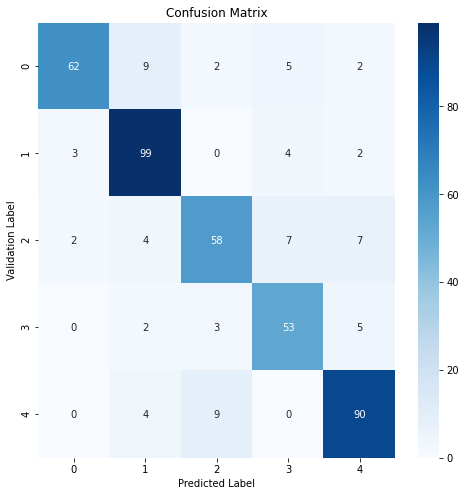

In [ ]:
confusion_mtx_resnet = confusion_matrix(y_true_val, y_pred_val) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx_resnet, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel("Validation Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
samples = total_X_test
predict = inception_model.predict_generator(test_generator, steps=np.ceil(samples/batch_size))

In [ ]:
predict.shape

(433, 5)

In [ ]:
X_test.shape

(433, 150, 150, 3)

In [ ]:
loss, acc = inception_model.evaluate_generator(test_generator, verbose=0)
print(f'Test loss: {loss:.2f}%')
print(f'Test accuracy: {acc*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 0.41%
Test accuracy: 85.91%


In [ ]:
y_pred = predict.argmax(axis=1)
y_true = y_test.argmax(axis=1)

print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87        72
           1       0.89      0.93      0.91       107
           2       0.86      0.77      0.81        87
           3       0.80      0.87      0.83        61
           4       0.84      0.87      0.86       106

    accuracy                           0.86       433
   macro avg       0.86      0.86      0.86       433
weighted avg       0.86      0.86      0.86       433



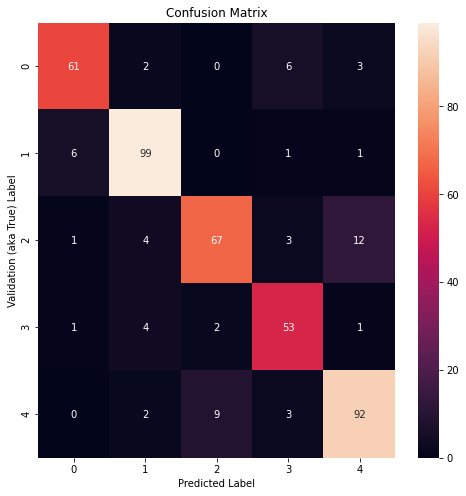

In [ ]:
confusion_mtx = confusion_matrix(y_true, y_pred) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True)
plt.xlabel("Predicted Label")
plt.ylabel("Validation Label")
plt.title("Confusion Matrix")
plt.show()